<a href="https://colab.research.google.com/github/anon-researchers/sliced_bures_flows/blob/master/reweighted_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install POT
! pip install celluloid
! pip install multipledispatch

     |████████████████████████████████| 440kB 8.6MB/s 


In [ ]:
! git clone https://github.com/anon-researchers/sliced_bures_flows
% cd sliced_bures_flows/src/

Cloning into 'sliced_bures_flows'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 132 (delta 53), reused 66 (delta 15), pack-reused 0
Receiving objects: 100% (132/132), 9.83 MiB | 17.72 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/sliced_bures_flows/src


In [ ]:
from utils import load_data
from utils import seed_everything
from utils import rand_Fourier

from utils_loss import loss
from utils_distances import w2_weighted

from TransformNet import TransformNet

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import optim
from celluloid import Camera
from tqdm import tqdm
from IPython import display

In [ ]:
class flow:
    def __init__(self, ftype, stype, dtype, init_weights=None, f=None, device='cuda'):
        self.ftype = ftype
        self.stype = stype
        self.dtype = dtype
        self.device = device
        self.init_weights = init_weights
        self.f = f
        self.weights = None
        self.loss = None
        self.f_op = None
        self.initialize()
    
    def initialize(self, optimizer=optim.Adam, lr=1e-3):
        weighted=False
        if self.init_weights is not None:
            weighted = True
            self.weights = torch.tensor(self.init_weights, dtype=torch.float, requires_grad=True, device=device)
            self.opt = optimizer([self.weights], lr)
        self.loss = loss(ftype=self.ftype, stype=self.stype.lower(), dtype=self.dtype.lower(), weighted=weighted)
        if self.ftype=='distributional-sliced':
            assert(self.f is not None)
            self.f_op = optimizer(self.f.parameters(), lr)

    def optimize(self, X, Y, num_projections=1000, r=1, lam=1):
        method_loss = self.loss.compute(X.to(device), Y.to(device), self.weights, num_projections=num_projections, r=r, f=self.f, f_op=self.f_op, lam=lam, device=self.device)
        self.opt.zero_grad()
        method_loss.backward()
        self.opt.step()
        return method_loss


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# General settings
seed = 123456
ftype = 'distributional-sliced'
# for Fourier approximation 
RFB = True
sigma = 0.2
bases = 200
radius = 0.9
# for sliced and distributional-sliced distances
slices = 200
# for distributional-sliced distances
lam = 1
# text for plots
text_RFB = '-----------------\nRFB applied\n#bases={},\nsigma={}\n-----------------\n'.format(bases,sigma) \
            if RFB else '-----------------\nRFB not applied\n-----------------\n'
if ftype=='sliced':
    text_settings = 'r={} for circular slicing,\n#slices={}\n{}'.format(radius,slices,text_RFB)
elif ftype=='max-sliced':
    text_settings = 'r={} for circular slicing,\n#slices=1\n{}'.format(radius,text_RFB)
elif ftype=='distributional-sliced':
    text_settings = 'r={} for circular slicing,\n#slices={}\n{}lam={}'.format(radius,slices,text_RFB,lam)
else:
    raise Exception('function type not found')

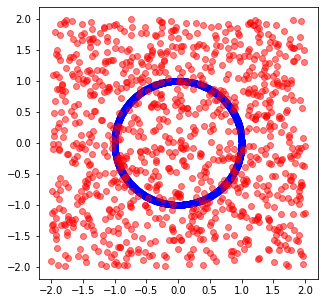

In [ ]:
#%%
seed_everything(seed)
# Target and source distributions
N = 1000  # Number of samples from p_X(target) and p_Y(target)

# Target:
# in  ['swiss_roll','circle','8gaussians','25gaussians']:
dataset_name = 'circle' 
noise = 0.0
X = load_data(name=dataset_name, n_samples=N, noise=noise)
# Number of dimensions "d"
_, d = X.shape
X -= X.mean(dim=0)[np.newaxis,:]  # Normalization

# Source:
# Y = np.random.normal(loc=meanX, scale=0.5, size=(N,d))
Y = torch.from_numpy((np.random.rand(N,d)-0.5)*4 ).float()
# Show the both distributions
fig = plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c='b')
plt.scatter(Y[:, 0], Y[:, 1],  c='r', alpha = 0.5)
plt.show()

In [ ]:
# %%
# Initial parameters
seed_everything(seed)
iter = 50
lr = 1e-3
temp = np.ones((N,))/N
# Kernel approximation by Random Fourier Bases
if RFB:
    rfb = rand_Fourier(X.shape[1], num_projections=bases, sigma=sigma)
    X_, Y_ = rfb.compute(X), rfb.compute(Y)
    RFBtext = 'RFB, '
else:
    X_ , Y_ = X, Y
    RFBtext = ''
# TransformNet instantiation
# tnet = TransformNet(X_.size(1)).to(device)
# op_tnet = optim.Adam(tnet.parameters(), lr=lr, betas=(0.5, 0.999))
# 
methods = [[None, flow(ftype,'linear','Wasserstein',init_weights=temp.copy(), f=TransformNet(X_.size(1)).to(device),device=device), flow(ftype,'circular','Wasserstein',init_weights=temp.copy(), f=TransformNet(X_.size(1)).to(device),device=device)],
           [None, flow(ftype,'linear','Bures',init_weights=temp.copy(), f=TransformNet(X_.size(1)).to(device),device=device), flow(ftype,'circular','Bures',init_weights=temp.copy(), f=TransformNet(X_.size(1)).to(device),device=device)],
           [None, flow(ftype,'linear','mean',init_weights=temp.copy(), f=TransformNet(X_.size(1)).to(device),device=device), flow(ftype,'circular','mean',init_weights=temp.copy(), f=TransformNet(X_.size(1)).to(device),device=device)]]
rows = np.array(methods, dtype=object).shape[0]
cols = np.array(methods, dtype=object).shape[1]

methods_colors = [['','#1f77b4','#ff7f0e'],
                  ['','#2ca02c','#d62728'],
                  ['','#9467bd','#8c564b']]
# Define the variables to store the loss (2-Wasserstein distance) for each defining function and each problem 
log_w2_dist = np.full([iter, rows, cols], np.nan)
# Titles and colors for legend display
titles = []
colors = []
for i in range(rows):
    for j in range(cols):
        if j==0:
            continue
        title = "{}{}, {} {}".format(RFBtext,methods[i][j].stype,ftype,methods[i][j].dtype)
        titles.append(title)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ot/lp/__init__.py:421: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)
/usr/local/lib/python3.7/dist-packages/ot/lp/__init__.py:421: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)
/usr/local/lib/python3.7/dist-packages/ot/lp/__init__.py:421: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)
/usr/local/lib/python3.7/dist-packages/ot/lp/__init__.py:421: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)
/usr/local/lib/python3.7/dist-packages/ot/lp/__init__.py:421: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)
/usr/local/lib/python3.7/dist-packages/ot/lp/__init__.py:421: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_co

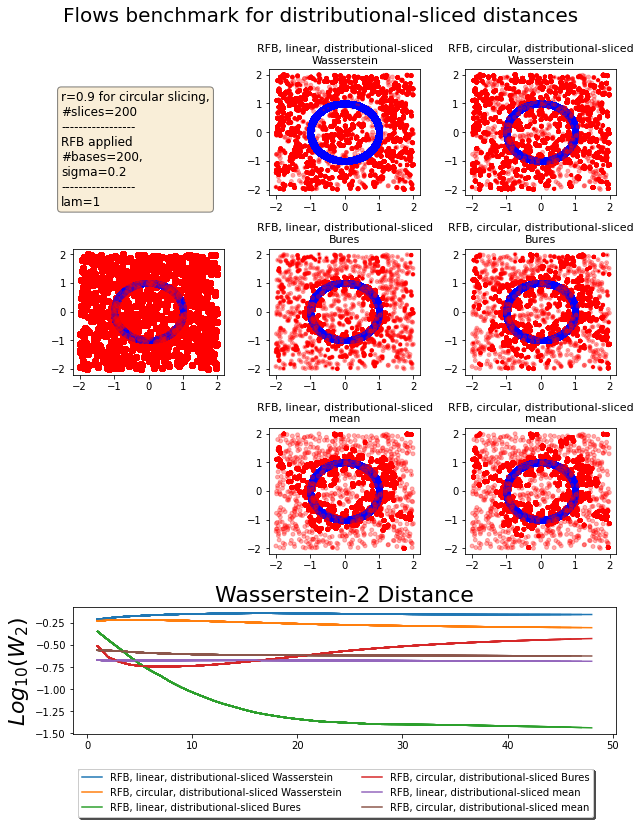

In [ ]:
# %%
# Weights optimization
seed_everything(seed)
fig, f_axs = plt.subplots(ncols=cols, nrows=rows+1, figsize=((cols)*3, (rows+1)*3));
camera = Camera(fig)
f_axs[0, 0].remove()
f_axs[2, 0].remove()
gs = f_axs[2, 0].get_gridspec()
# remove the underlying axes
for ax in f_axs[-1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[-1, :])
axbig.set_title('Wasserstein-2 Distance', fontsize=22)
axbig.set_ylabel(r'$Log_{10}(W_2)$', fontsize=22)

suptitle = 'Flows benchmark for {} distances'.format(ftype)
suptitle_size = 25 if ftype=='sliced' or ftype=='max-sliced' else 20
fig.suptitle(suptitle, fontsize=suptitle_size)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig.text(0.1, 0.75, text_settings,size=12, bbox=props)
title_size = 15 if ftype=='sliced' else 13 if ftype=='max-sliced' else 11
# Settings printed
for t in tqdm(range(iter), position=0, leave=True):
    methods_loss = np.full([rows,cols], None)
    for i in range(rows):
        for j in range(cols):
            if j==0:
                continue
            
            stype, dtype = methods[i][j].stype, methods[i][j].dtype
            nu = methods[i][j].weights.detach().cpu().numpy()
            nu = np.maximum(0,nu).astype(np.float64)
            nu = nu/np.sum(nu)
            w2 = w2_weighted(X, Y, torch.tensor(nu,dtype=torch.float))
            w2 = np.nan if w2==0.0 else w2
            log_w2_dist[t,i,j] = np.log10(w2)
            axbig.plot(log_w2_dist[:t,i,j], color = methods_colors[i][j])

            nu = nu/np.max(nu)*15 # for plotting purposes
            f_axs[i][j].scatter(X[:, 0], X[:, 1], c='b')
            f_axs[i][j].scatter(Y[:, 0], Y[:, 1], s=nu, c='r', alpha=0.3)
            title = "{}{}, {}\n{}".format(RFBtext,stype,ftype,dtype)

            f_axs[i][j].set_title(title, fontsize=title_size)

            l = methods[i][j].optimize(X_, Y_, num_projections=slices, r=radius, lam=lam)

    axbig.legend(titles, fontsize=10, bbox_to_anchor=(-.0,-.7), loc="lower left",
                    ncol=2, fancybox=True, shadow=True)
    f_axs[1][0].scatter(X[:, 0], X[:, 1], c='b')
    f_axs[1][0].scatter(Y[:, 0], Y[:, 1], c='r', alpha=0.3)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    camera.snap()
# fig.clear()
plt.show()

In [ ]:
animation_full = camera.animate()
animation_full.save('animation_{}_RFB-{}.mp4'.format(ftype,RFB))
display.HTML(animation_full.to_html5_video())